In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist
data = mnist.load_data(path="mnist.npz")
(train_images, train_labels), (test_images, test_labels) = data

In [3]:
train_images[0].shape

(28, 28)

item: 5


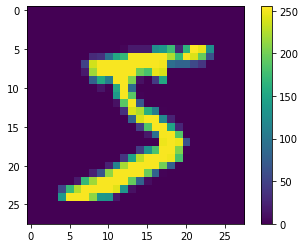

In [4]:
plt.imshow(train_images[0])
plt.colorbar()
print("item:",train_labels[0])

In [5]:
# normalise data
train_images = train_images / 255
test_images = test_images / 255


In [6]:
# define model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu), # why 128? and why use activation function?
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [7]:
# compile model
model.compile(optimizer=tf.optimizers.Adam(), loss = "sparse_categorical_crossentropy", metrics="accuracy")

In [8]:
# creating callback to stop training when reaching 98% accuracy
class AccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.98): 
      print("\nReached 98% accuracy. Cancelling training!")
      self.model.stop_training = True

In [8]:
# train model
model.fit(train_images, train_labels, epochs=10, callbacks=[AccuracyCallback()])

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2590 - accuracy: 0.9256
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1167 - accuracy: 0.9653
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0789 - accuracy: 0.9765
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0575 - accuracy: 0.9823

Reached 98% accuracy. Cancelling training!


In [9]:
# evaluate model
model.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.0793 - accuracy: 0.9753


[0.07932295650243759, 0.9753000140190125]

# Read my handwriting with the model

In [9]:
# import matplotlib.image as mpimg
from PIL import Image
import numpy as np

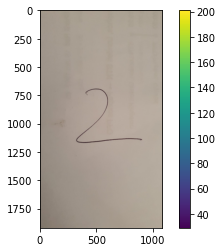

In [30]:
# load my picture with PIL
filename = 'data/Numbers/number2.jpg'
img = Image.open(filename)
plt.imshow(img)
plt.colorbar()

In [31]:
# change to greyscale (255)
img = img.convert("L")

In [32]:
# sample pixels for 28x28
img = img.resize((28,28))

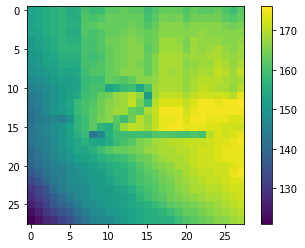

In [33]:
# preview
plt.imshow(img)
plt.colorbar()

In [223]:
# prep data
img_as_array = np.array(img.getdata())
img_as_array.shape = (28,28)
img_as_array = img_as_array / 255

In [224]:
# model predict
prediction = model.predict(np.array([img_as_array]))
prediction_hash = dict(zip(prediction[0], range(0,10)))
# the answer we are looking for is 2
print(prediction_hash.get(max(prediction_hash)), "with probability of:",max(prediction_hash) )

5 with probability of: 0.8187928


# IMPROVE THE MODEL BY REMOVING SHADOWS AND NOISE FROM PICTURE

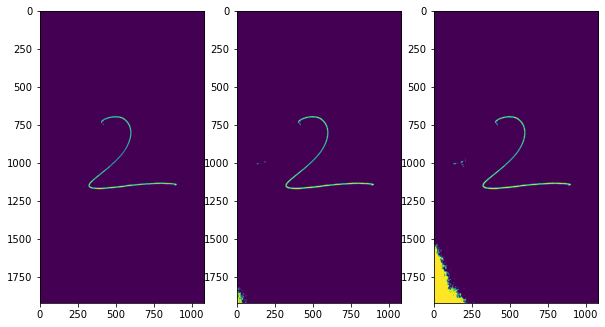

In [11]:
# remove noise
img = Image.open(filename)
multiBands = img.split()
redband = multiBands[0].point(lambda p: p < 120)
greenband = multiBands[1].point(lambda p: p < 120)
blueband = multiBands[2].point(lambda p: p < 120)
fig, ax = plt.subplots(1,3, figsize=[10,10])
ax[0].imshow(redband)
ax[1].imshow(greenband)
ax[2].imshow(blueband)

Issues:
- when we resize we lose data so it all becomes a jumble
- when we switch to grayscale it flattens out and gives 0s
- cant merge the RGBs for some reason we just get 0s

One idea is to apply a convolution NN or a filter to make the features stand out. another way is to get the array down and then use `Image.fromarray()`

# READ:
- whats softmax
- whats adam
- whats sparse_categorical_crossentropy

In [23]:
# np.array(redband.getdata())
# plt.imshow(Image.merge("RGB", (redband, greenband, blueband)))

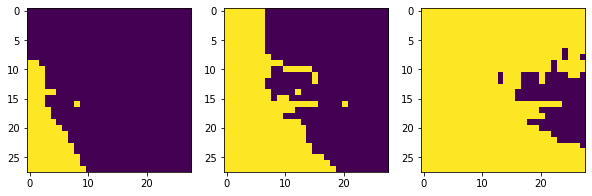

In [19]:
resized = img.resize((28,28)).split()
threashold = 157
redband = resized[0].point(lambda p: p < threashold)
greenband = resized[1].point(lambda p: p < threashold)
blueband = resized[2].point(lambda p: p < threashold)

fig, ax = plt.subplots(1,3, figsize=[10,10])
ax[0].imshow(redband)
ax[1].imshow(greenband)
ax[2].imshow(blueband)

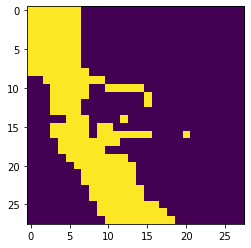

In [22]:
plt.imshow(Image.fromarray(np.asarray(greenband) - np.asarray(redband)))

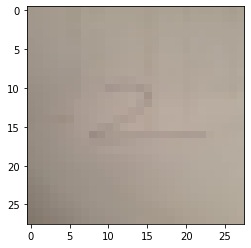

In [8]:
# we lost a lot of data and its even hard for a human to see what the number is
plt.imshow(img.resize((28,28)))

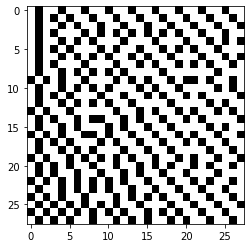

In [236]:
# convert to black and white
plt.imshow(img.resize((28,28)).convert("1"))

# Convolution Neural Network

applies ML to extract features from image so that our processing takes less time. 

Also, it allows the model to learn the features and not just the location of the pixels. So if your picture is shifted, it can still estimate the answer 

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=(28,28,1)), # why 64 filters? and why kernel size of 3x3?
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [23]:
train_images= train_images.reshape(60000, 28, 28, 1) 
# why do we need to reshape it like this?

In [25]:
class AccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc') >= 0.9): 
      print("\nReached 90% accuracy. Cancelling training!")
      self.model.stop_training = True

In [27]:
model.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(train_images, train_labels, epochs=5, callbacks=[AccuracyCallback()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [29]:
test_images= test_images.reshape(10000, 28, 28, 1) 
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.0364 - accuracy: 0.9888


[0.0363692045211792, 0.9887999892234802]

In [46]:
# model predict
img_as_array = np.array(img.getdata()).reshape(1, 28, 28, 1)
prediction = model.predict(img_as_array)
prediction_hash = dict(zip(prediction[0], range(0,10)))
# the answer we are looking for is 2
print(prediction_hash.get(max(prediction_hash)), "with probability of:",max(prediction_hash) )

1 with probability of: 0.9999368


to see what each convolution layer is extracting we can visualise it like this

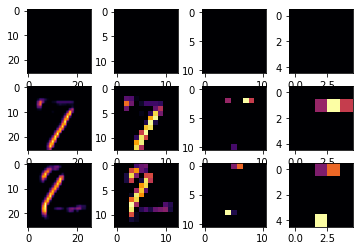

In [56]:
#visualise convolutions
fig, axs = plt.subplots(3,4)
FIRST_IMAGE= img_as_array
SECOND_IMAGE= test_images[0].reshape(1,28,28,1)
THIRD_IMAGE=test_images[1].reshape(1,28,28,1)
CONVOLUTION_NUMBER = 1

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(0,4):
    fig1 = activation_model.predict(FIRST_IMAGE)[x]
    axs[0,x].imshow(fig1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axs[0,x].grid(False)

    fig2 = activation_model.predict(SECOND_IMAGE)[x]
    axs[1,x].imshow(fig2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axs[1,x].grid(False)

    fig3 = activation_model.predict(THIRD_IMAGE)[x]
    axs[2,x].imshow(fig3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axs[2,x].grid(False)